In [1]:
# %cd drive/My\ Drive/Colab\ Notebooks

In [2]:
# train_networks: Training CNN to be used by the main program

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os
import imutils
from processing import *

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, DataLoader

from skimage.segmentation import watershed
from skimage.morphology import disk
from skimage.feature import peak_local_max
from skimage.filters import meijering

from scipy import ndimage as ndi

BATCH_SIZE = 3
IMAGES_LIMIT = 2000

def plot_two_images(imgL, imgR, titleL, titleR):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(imgL, cmap='gray')
    plt.title(titleL)
    f.add_subplot(1,2, 2)
    plt.imshow(imgR, cmap='gray')
    plt.title(titleR)
    plt.show(block=True)
    

# def load_data(dataset):
#     data = []
#     paths = [os.path.join(dataset, '01'), os.path.join(dataset, '02')]
#     for path in paths:
#         mask_path = path + '_ST'
#         mask_path = os.path.join(mask_path, 'SEG')
#         for f in os.listdir(mask_path):
#             if not f.endswith(".tif"):
#                 continue
#             image = cv2.imread(os.path.join(path, f.replace('man_seg', 't')), cv2.IMREAD_GRAYSCALE)
#             image = equalize_clahe(image).astype(np.float32)
#             mask = cv2.imread(os.path.join(mask_path, f), cv2.IMREAD_UNCHANGED)
#             print("   Loaded " + os.path.join(mask_path, f) + ", " + os.path.join(path, f.replace('man_seg', 't')))
            
#             # Generate the Cell Mask and Markers from the Mask
#             cell_mask = (mask > 0).astype(np.uint8)
#             markers = (get_markers(mask) > 0).astype(np.uint8)
#             weight_map = get_weight_map(markers)
            
#             # Pack the data for the DataLoader
#             target = (cell_mask, markers, weight_map)
#             data.append((np.array([image]), target))

#     train_size = int(0.8 * len(data))
#     test_size = len(data) - train_size
#     train_data, test_data = random_split(data, [train_size, test_size])
#     trainLoader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
#     testLoader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
#     return trainLoader, testLoader

def load_data(dataset):
    data = []
    path = os.path.join(dataset, "originals")
    clahe_path = path.replace("originals", "clahes")
    mask_path = path.replace("originals", "masks")
    markers_path = path.replace("originals", "markers")
    wm_path = path.replace("originals", "weight_maps")
    
    
    count = 0
    for f in os.listdir(path):
        # Limits dataset size for RAM compatibility
        if count >= IMAGES_LIMIT:
            break
        
        if not f.endswith(".npy"):
            continue
#         image = cv2.imread(os.path.join(path, f), cv2.IMREAD_GRAYSCALE)
#         clahe = cv2.imread(os.path.join(clahe_path, f), cv2.IMREAD_GRAYSCALE).astype(np.float32)
#         cell_mask = cv2.imread(os.path.join(mask_path, f), cv2.IMREAD_UNCHANGED)
#         markers = cv2.imread(os.path.join(markers_path, f), cv2.IMREAD_UNCHANGED)
#         weight_map = cv2.imread(os.path.join(wm_path, f), cv2.IMREAD_UNCHANGED)
    
        count += 1
    
#         image = np.load(os.path.join(path, f))
        clahe = np.load(os.path.join(clahe_path, f))
        cell_mask = np.load(os.path.join(mask_path, f))
        markers = np.load(os.path.join(markers_path, f))
        weight_map = np.load(os.path.join(wm_path, f))
        print("   Loaded " + os.path.join(mask_path, f) + ", " + os.path.join(path, f.replace('mask', '')))

        # Pack the data for the DataLoader
        target = (cell_mask, markers, weight_map)
        data.append((np.array([clahe]), target))
    
    train_size = int(0.8 * len(data))
    test_size = len(data) - train_size
    train_data, test_data = random_split(data, [train_size, test_size])
    trainLoader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    testLoader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
    return trainLoader, testLoader

In [3]:
# Class for creating the CNN
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv7 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv8 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv9 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv10 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv11 = nn.Conv2d(768, 256, 3, padding=1)
        self.conv12 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv13 = nn.Conv2d(384, 128, 3, padding=1)
        self.conv14 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv15 = nn.Conv2d(192, 64, 3, padding=1)
        self.conv16 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv17 = nn.Conv2d(96, 32, 3, padding=1)
        self.conv18 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv_out = nn.Conv2d(32, 2, 1)
        
    def forward(self, x):
        """
        Forward pass through the network
        """
        x = F.relu(self.conv1(x))
        contraction_32 = F.relu(self.conv2(x))
        
        x = F.max_pool2d(contraction_32, kernel_size=2)
        x = F.relu(self.conv3(x))
        contraction_64 = F.relu(self.conv4(x))
        
        x = F.max_pool2d(contraction_64, kernel_size=2)
        x = F.relu(self.conv5(x))
        contraction_128 = F.relu(self.conv6(x))
        
        x = F.max_pool2d(contraction_128, kernel_size=2)
        x = F.relu(self.conv7(x))
        contraction_256 = F.relu(self.conv8(x))
        
        x = F.max_pool2d(contraction_256, kernel_size=2)
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.cat((contraction_256, x), dim=1)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.cat((contraction_128, x), dim=1)
        x = F.relu(self.conv13(x))
        x = F.relu(self.conv14(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.cat((contraction_64, x), dim=1)
        x = F.relu(self.conv15(x))
        x = F.relu(self.conv16(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.cat((contraction_32, x), dim=1)
        x = F.relu(self.conv17(x))
        x = F.relu(self.conv18(x))
        
        x = self.conv_out(x)
        output = F.sigmoid(x)
        return output

def weighted_mean_sq_error(inputs, targets_m, targets_c, weights):

#     Weighted Mean Squared Error Loss takes in a weight map
#     and computes loss based on both outputs
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('.', end='')
    
#     print(inputs.shape, targets_m.shape)
    
    inputs = inputs.to(device)
    targets = [targets_m.to(device), targets_c.to(device)]
    weights = weights.to(device)
    loss = torch.zeros(inputs.shape[0])

    # Calculate loss for each sample in the batch
    for sample in range(inputs.shape[0]):
#         print("Sample", sample+1)
        sample_loss, total_weight = 0.0, 0.0
        
        pred_markers = inputs[sample][0]
        pred_cmask = inputs[sample][1]
        
#         pimg(pred_markers.cpu().detach().numpy())
#         pimg(pred_cmasks.cpu().detach().numpy())
#         pimg(weights.cpu().detach().numpy())
        
        exp_markers = targets[0][sample]
        exp_cmask = targets[1][sample]
        
        numerator = weights[sample] * ( (pred_markers-exp_markers)**2 + (pred_cmask-exp_cmask)**2 )
        
        numerator = torch.sum(numerator)
        
        denominator = torch.sum(weights[sample])
#         print(np.unique(exp_markers), np.unique(exp_cmasks), numerator, denominator)
        sample_loss = 0.5 * (numerator/denominator)
        
        loss[sample] = sample_loss

    return torch.mean(loss)

"""
def get_score(outputs, ground_truth):
    
    #Calculates Accuracy Score across the batch
    
    score = 0
    batch_size = outputs.shape[0]
    total = outputs.shape[1] * outputs.shape[2]
    for sample in range(batch_size):
        num_correct = torch.sum(outputs[sample] == ground_truth[sample]).item()
        score += float(num_correct) / total

    return score / batch_size
"""


def main():
    """
    Train 2 networks for predicting markers and the cell mask respectively
    Set trains on data from "Sequence 1 Masks" and "Sequence 2 Masks"
    and save the models
    """    
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using device: " + str(device))
    
    # Net predicts the markers and cells
    net = Network().to(device)
    
    # Calculate loss with Weighted MSE
    criterion = weighted_mean_sq_error
    
    # Optimising using Adam algorithm
    optimiser = optim.Adam(net.parameters(), lr=0.001)
    
    min_loss = 9999999999
    file_count_c = 0
    file_count_m = 0
    
    # Iterate over a number of epochs on the data
    for epoch in range(100):
        for i, batch in enumerate(trainLoader, 0):
            x = batch[0].to(device)
            target = batch[1]
            cell_masks, markers = target[0].to(device), target[1].to(device) # Unpack target data
            weight_map = target[2].to(device)

            # Clear gradients from last step
            optimiser.zero_grad()
            
            # Predict the markers from the image
            output = net(x)
            # loss_m = criterion(output_m, markers.long())
            loss = criterion(output, markers.float(), cell_masks.float(), weight_map)
            loss.backward()
            optimiser.step()

            if i == 0 or (i + 1) % 960 == 0:
                print(f"Epoch: {epoch+1}, Batch: {i + 1}")
                print(f"Loss: {loss.item():.2f}")
                
                plt.imshow(x[0][0].cpu(), cmap='gray')
                plt.title("Input")
                plt.show()

                # Get the predicted Cell Mask and Markers for one of the images
                pred_m = ( (output[0][0] > 0.5).int() ).cpu()
                pred_c = ( (output[0][1] > 0.5).int() ).cpu()
                
                # Compare predicted to true images
                plot_two_images(pred_c.cpu(), cell_masks[0].cpu(), "Predicted Cell Mask", "True Cell Mask")
                plot_two_images(pred_m.cpu(), markers[0].cpu(), "Predicted Markers", "True Markers")


        # Test on the evaluation set
        print("\n--- Evaluation ---")
        net.eval()
        with torch.no_grad():
            running_loss = 0.0
            for i, batch in enumerate(testLoader):
                x = batch[0].to(device)
                target = batch[1]
                cell_masks, markers = target[0].to(device), target[1].to(device) # Unpack target data
                weight_map = target[2].to(device)

                output = net(x)
                
                pred_m = (output[:,0] > 0.5).int()
                pred_c = (output[:,1] > 0.5).int()

                running_loss += weighted_mean_sq_error(output, markers.float(), cell_masks.float(), weight_map)

                if i == 0:
                    plt.imshow(x[0][0].cpu(), cmap='gray')
                    plt.title("Input")
                    plt.show()

                    # Compare predicted to true images
                    plot_two_images(pred_c[0].cpu(), cell_masks[0].cpu(), "Predicted Cell Mask", "True Cell Mask")
                    plot_two_images(pred_m[0].cpu(), markers[0].cpu(), "Predicted Markers", "True Markers")

            loss = running_loss / len(testLoader)
            
            if loss < min_loss:
                torch.save(net.state_dict(), "./CNN_min_loss_{}.pth".format(file_count_c))
                min_loss = loss
                file_count_c += 1
                file_count_c %= 20
            
            print(f"EPOCH {epoch+1} LOSS: {loss:.3f}\nMin Loss: {min_loss:.3f}\n\n")
        net.train()

    torch.save(net.state_dict(), "./CNN_v1.pth")
    print("Saved models. Min Loss : ", str(min_loss))

In [4]:
print("Loading Data...")
trainLoader, testLoader = load_data('DIC-3_cache')
print("Finished.")

Loading Data...
   Loaded DIC-3_cache\masks\t0.npy, DIC-3_cache\originals\t0.npy
   Loaded DIC-3_cache\masks\t1.npy, DIC-3_cache\originals\t1.npy
   Loaded DIC-3_cache\masks\t10.npy, DIC-3_cache\originals\t10.npy
   Loaded DIC-3_cache\masks\t100.npy, DIC-3_cache\originals\t100.npy
   Loaded DIC-3_cache\masks\t1000.npy, DIC-3_cache\originals\t1000.npy
   Loaded DIC-3_cache\masks\t1001.npy, DIC-3_cache\originals\t1001.npy
   Loaded DIC-3_cache\masks\t1002.npy, DIC-3_cache\originals\t1002.npy
   Loaded DIC-3_cache\masks\t1003.npy, DIC-3_cache\originals\t1003.npy
   Loaded DIC-3_cache\masks\t1004.npy, DIC-3_cache\originals\t1004.npy
   Loaded DIC-3_cache\masks\t1005.npy, DIC-3_cache\originals\t1005.npy
   Loaded DIC-3_cache\masks\t1006.npy, DIC-3_cache\originals\t1006.npy
   Loaded DIC-3_cache\masks\t1007.npy, DIC-3_cache\originals\t1007.npy
   Loaded DIC-3_cache\masks\t1008.npy, DIC-3_cache\originals\t1008.npy
   Loaded DIC-3_cache\masks\t1009.npy, DIC-3_cache\originals\t1009.npy
   Loade

   Loaded DIC-3_cache\masks\t1102.npy, DIC-3_cache\originals\t1102.npy
   Loaded DIC-3_cache\masks\t1103.npy, DIC-3_cache\originals\t1103.npy
   Loaded DIC-3_cache\masks\t1104.npy, DIC-3_cache\originals\t1104.npy
   Loaded DIC-3_cache\masks\t1105.npy, DIC-3_cache\originals\t1105.npy
   Loaded DIC-3_cache\masks\t1106.npy, DIC-3_cache\originals\t1106.npy
   Loaded DIC-3_cache\masks\t1107.npy, DIC-3_cache\originals\t1107.npy
   Loaded DIC-3_cache\masks\t1108.npy, DIC-3_cache\originals\t1108.npy
   Loaded DIC-3_cache\masks\t1109.npy, DIC-3_cache\originals\t1109.npy
   Loaded DIC-3_cache\masks\t111.npy, DIC-3_cache\originals\t111.npy
   Loaded DIC-3_cache\masks\t1110.npy, DIC-3_cache\originals\t1110.npy
   Loaded DIC-3_cache\masks\t1111.npy, DIC-3_cache\originals\t1111.npy
   Loaded DIC-3_cache\masks\t1112.npy, DIC-3_cache\originals\t1112.npy
   Loaded DIC-3_cache\masks\t1113.npy, DIC-3_cache\originals\t1113.npy
   Loaded DIC-3_cache\masks\t1114.npy, DIC-3_cache\originals\t1114.npy
   Loade

   Loaded DIC-3_cache\masks\t1209.npy, DIC-3_cache\originals\t1209.npy
   Loaded DIC-3_cache\masks\t121.npy, DIC-3_cache\originals\t121.npy
   Loaded DIC-3_cache\masks\t1210.npy, DIC-3_cache\originals\t1210.npy
   Loaded DIC-3_cache\masks\t1211.npy, DIC-3_cache\originals\t1211.npy
   Loaded DIC-3_cache\masks\t1212.npy, DIC-3_cache\originals\t1212.npy
   Loaded DIC-3_cache\masks\t1213.npy, DIC-3_cache\originals\t1213.npy
   Loaded DIC-3_cache\masks\t1214.npy, DIC-3_cache\originals\t1214.npy
   Loaded DIC-3_cache\masks\t1215.npy, DIC-3_cache\originals\t1215.npy
   Loaded DIC-3_cache\masks\t1216.npy, DIC-3_cache\originals\t1216.npy
   Loaded DIC-3_cache\masks\t1217.npy, DIC-3_cache\originals\t1217.npy
   Loaded DIC-3_cache\masks\t1218.npy, DIC-3_cache\originals\t1218.npy
   Loaded DIC-3_cache\masks\t1219.npy, DIC-3_cache\originals\t1219.npy
   Loaded DIC-3_cache\masks\t122.npy, DIC-3_cache\originals\t122.npy
   Loaded DIC-3_cache\masks\t1220.npy, DIC-3_cache\originals\t1220.npy
   Loaded 

   Loaded DIC-3_cache\masks\t1317.npy, DIC-3_cache\originals\t1317.npy
   Loaded DIC-3_cache\masks\t1318.npy, DIC-3_cache\originals\t1318.npy
   Loaded DIC-3_cache\masks\t1319.npy, DIC-3_cache\originals\t1319.npy
   Loaded DIC-3_cache\masks\t132.npy, DIC-3_cache\originals\t132.npy
   Loaded DIC-3_cache\masks\t1320.npy, DIC-3_cache\originals\t1320.npy
   Loaded DIC-3_cache\masks\t1321.npy, DIC-3_cache\originals\t1321.npy
   Loaded DIC-3_cache\masks\t1322.npy, DIC-3_cache\originals\t1322.npy
   Loaded DIC-3_cache\masks\t1323.npy, DIC-3_cache\originals\t1323.npy
   Loaded DIC-3_cache\masks\t1324.npy, DIC-3_cache\originals\t1324.npy
   Loaded DIC-3_cache\masks\t1325.npy, DIC-3_cache\originals\t1325.npy
   Loaded DIC-3_cache\masks\t1326.npy, DIC-3_cache\originals\t1326.npy
   Loaded DIC-3_cache\masks\t1327.npy, DIC-3_cache\originals\t1327.npy
   Loaded DIC-3_cache\masks\t1328.npy, DIC-3_cache\originals\t1328.npy
   Loaded DIC-3_cache\masks\t1329.npy, DIC-3_cache\originals\t1329.npy
   Loade

   Loaded DIC-3_cache\masks\t1423.npy, DIC-3_cache\originals\t1423.npy
   Loaded DIC-3_cache\masks\t1424.npy, DIC-3_cache\originals\t1424.npy
   Loaded DIC-3_cache\masks\t1425.npy, DIC-3_cache\originals\t1425.npy
   Loaded DIC-3_cache\masks\t1426.npy, DIC-3_cache\originals\t1426.npy
   Loaded DIC-3_cache\masks\t1427.npy, DIC-3_cache\originals\t1427.npy
   Loaded DIC-3_cache\masks\t1428.npy, DIC-3_cache\originals\t1428.npy
   Loaded DIC-3_cache\masks\t1429.npy, DIC-3_cache\originals\t1429.npy
   Loaded DIC-3_cache\masks\t143.npy, DIC-3_cache\originals\t143.npy
   Loaded DIC-3_cache\masks\t1430.npy, DIC-3_cache\originals\t1430.npy
   Loaded DIC-3_cache\masks\t1431.npy, DIC-3_cache\originals\t1431.npy
   Loaded DIC-3_cache\masks\t1432.npy, DIC-3_cache\originals\t1432.npy
   Loaded DIC-3_cache\masks\t1433.npy, DIC-3_cache\originals\t1433.npy
   Loaded DIC-3_cache\masks\t1434.npy, DIC-3_cache\originals\t1434.npy
   Loaded DIC-3_cache\masks\t1435.npy, DIC-3_cache\originals\t1435.npy
   Loade

   Loaded DIC-3_cache\masks\t1530.npy, DIC-3_cache\originals\t1530.npy
   Loaded DIC-3_cache\masks\t1531.npy, DIC-3_cache\originals\t1531.npy
   Loaded DIC-3_cache\masks\t1532.npy, DIC-3_cache\originals\t1532.npy
   Loaded DIC-3_cache\masks\t1533.npy, DIC-3_cache\originals\t1533.npy
   Loaded DIC-3_cache\masks\t1534.npy, DIC-3_cache\originals\t1534.npy
   Loaded DIC-3_cache\masks\t1535.npy, DIC-3_cache\originals\t1535.npy
   Loaded DIC-3_cache\masks\t1536.npy, DIC-3_cache\originals\t1536.npy
   Loaded DIC-3_cache\masks\t1537.npy, DIC-3_cache\originals\t1537.npy
   Loaded DIC-3_cache\masks\t1538.npy, DIC-3_cache\originals\t1538.npy
   Loaded DIC-3_cache\masks\t1539.npy, DIC-3_cache\originals\t1539.npy
   Loaded DIC-3_cache\masks\t154.npy, DIC-3_cache\originals\t154.npy
   Loaded DIC-3_cache\masks\t1540.npy, DIC-3_cache\originals\t1540.npy
   Loaded DIC-3_cache\masks\t1541.npy, DIC-3_cache\originals\t1541.npy
   Loaded DIC-3_cache\masks\t1542.npy, DIC-3_cache\originals\t1542.npy
   Loade

   Loaded DIC-3_cache\masks\t1636.npy, DIC-3_cache\originals\t1636.npy
   Loaded DIC-3_cache\masks\t1637.npy, DIC-3_cache\originals\t1637.npy
   Loaded DIC-3_cache\masks\t1638.npy, DIC-3_cache\originals\t1638.npy
   Loaded DIC-3_cache\masks\t1639.npy, DIC-3_cache\originals\t1639.npy
   Loaded DIC-3_cache\masks\t164.npy, DIC-3_cache\originals\t164.npy
   Loaded DIC-3_cache\masks\t1640.npy, DIC-3_cache\originals\t1640.npy
   Loaded DIC-3_cache\masks\t1641.npy, DIC-3_cache\originals\t1641.npy
   Loaded DIC-3_cache\masks\t1642.npy, DIC-3_cache\originals\t1642.npy
   Loaded DIC-3_cache\masks\t1643.npy, DIC-3_cache\originals\t1643.npy
   Loaded DIC-3_cache\masks\t1644.npy, DIC-3_cache\originals\t1644.npy
   Loaded DIC-3_cache\masks\t1645.npy, DIC-3_cache\originals\t1645.npy
   Loaded DIC-3_cache\masks\t1646.npy, DIC-3_cache\originals\t1646.npy
   Loaded DIC-3_cache\masks\t1647.npy, DIC-3_cache\originals\t1647.npy
   Loaded DIC-3_cache\masks\t1648.npy, DIC-3_cache\originals\t1648.npy
   Loade

   Loaded DIC-3_cache\masks\t1742.npy, DIC-3_cache\originals\t1742.npy
   Loaded DIC-3_cache\masks\t1743.npy, DIC-3_cache\originals\t1743.npy
   Loaded DIC-3_cache\masks\t1744.npy, DIC-3_cache\originals\t1744.npy
   Loaded DIC-3_cache\masks\t1745.npy, DIC-3_cache\originals\t1745.npy
   Loaded DIC-3_cache\masks\t1746.npy, DIC-3_cache\originals\t1746.npy
   Loaded DIC-3_cache\masks\t1747.npy, DIC-3_cache\originals\t1747.npy
   Loaded DIC-3_cache\masks\t1748.npy, DIC-3_cache\originals\t1748.npy
   Loaded DIC-3_cache\masks\t1749.npy, DIC-3_cache\originals\t1749.npy
   Loaded DIC-3_cache\masks\t175.npy, DIC-3_cache\originals\t175.npy
   Loaded DIC-3_cache\masks\t1750.npy, DIC-3_cache\originals\t1750.npy
   Loaded DIC-3_cache\masks\t1751.npy, DIC-3_cache\originals\t1751.npy
   Loaded DIC-3_cache\masks\t1752.npy, DIC-3_cache\originals\t1752.npy
   Loaded DIC-3_cache\masks\t1753.npy, DIC-3_cache\originals\t1753.npy
   Loaded DIC-3_cache\masks\t1754.npy, DIC-3_cache\originals\t1754.npy
   Loade

   Loaded DIC-3_cache\masks\t1848.npy, DIC-3_cache\originals\t1848.npy
   Loaded DIC-3_cache\masks\t1849.npy, DIC-3_cache\originals\t1849.npy
   Loaded DIC-3_cache\masks\t185.npy, DIC-3_cache\originals\t185.npy
   Loaded DIC-3_cache\masks\t1850.npy, DIC-3_cache\originals\t1850.npy
   Loaded DIC-3_cache\masks\t1851.npy, DIC-3_cache\originals\t1851.npy
   Loaded DIC-3_cache\masks\t1852.npy, DIC-3_cache\originals\t1852.npy
   Loaded DIC-3_cache\masks\t1853.npy, DIC-3_cache\originals\t1853.npy
   Loaded DIC-3_cache\masks\t1854.npy, DIC-3_cache\originals\t1854.npy
   Loaded DIC-3_cache\masks\t1855.npy, DIC-3_cache\originals\t1855.npy
   Loaded DIC-3_cache\masks\t1856.npy, DIC-3_cache\originals\t1856.npy
   Loaded DIC-3_cache\masks\t1857.npy, DIC-3_cache\originals\t1857.npy
   Loaded DIC-3_cache\masks\t1858.npy, DIC-3_cache\originals\t1858.npy
   Loaded DIC-3_cache\masks\t1859.npy, DIC-3_cache\originals\t1859.npy
   Loaded DIC-3_cache\masks\t186.npy, DIC-3_cache\originals\t186.npy
   Loaded 

   Loaded DIC-3_cache\masks\t1953.npy, DIC-3_cache\originals\t1953.npy
   Loaded DIC-3_cache\masks\t1954.npy, DIC-3_cache\originals\t1954.npy
   Loaded DIC-3_cache\masks\t1955.npy, DIC-3_cache\originals\t1955.npy
   Loaded DIC-3_cache\masks\t1956.npy, DIC-3_cache\originals\t1956.npy
   Loaded DIC-3_cache\masks\t1957.npy, DIC-3_cache\originals\t1957.npy
   Loaded DIC-3_cache\masks\t1958.npy, DIC-3_cache\originals\t1958.npy
   Loaded DIC-3_cache\masks\t1959.npy, DIC-3_cache\originals\t1959.npy
   Loaded DIC-3_cache\masks\t196.npy, DIC-3_cache\originals\t196.npy
   Loaded DIC-3_cache\masks\t1960.npy, DIC-3_cache\originals\t1960.npy
   Loaded DIC-3_cache\masks\t1961.npy, DIC-3_cache\originals\t1961.npy
   Loaded DIC-3_cache\masks\t1962.npy, DIC-3_cache\originals\t1962.npy
   Loaded DIC-3_cache\masks\t1963.npy, DIC-3_cache\originals\t1963.npy
   Loaded DIC-3_cache\masks\t1964.npy, DIC-3_cache\originals\t1964.npy
   Loaded DIC-3_cache\masks\t1965.npy, DIC-3_cache\originals\t1965.npy
   Loade

   Loaded DIC-3_cache\masks\t2058.npy, DIC-3_cache\originals\t2058.npy
   Loaded DIC-3_cache\masks\t2059.npy, DIC-3_cache\originals\t2059.npy
   Loaded DIC-3_cache\masks\t206.npy, DIC-3_cache\originals\t206.npy
   Loaded DIC-3_cache\masks\t2060.npy, DIC-3_cache\originals\t2060.npy
   Loaded DIC-3_cache\masks\t2061.npy, DIC-3_cache\originals\t2061.npy
   Loaded DIC-3_cache\masks\t2062.npy, DIC-3_cache\originals\t2062.npy
   Loaded DIC-3_cache\masks\t2063.npy, DIC-3_cache\originals\t2063.npy
   Loaded DIC-3_cache\masks\t2064.npy, DIC-3_cache\originals\t2064.npy
   Loaded DIC-3_cache\masks\t2065.npy, DIC-3_cache\originals\t2065.npy
   Loaded DIC-3_cache\masks\t2066.npy, DIC-3_cache\originals\t2066.npy
   Loaded DIC-3_cache\masks\t2067.npy, DIC-3_cache\originals\t2067.npy
   Loaded DIC-3_cache\masks\t2068.npy, DIC-3_cache\originals\t2068.npy
   Loaded DIC-3_cache\masks\t2069.npy, DIC-3_cache\originals\t2069.npy
   Loaded DIC-3_cache\masks\t207.npy, DIC-3_cache\originals\t207.npy
   Loaded 

   Loaded DIC-3_cache\masks\t2162.npy, DIC-3_cache\originals\t2162.npy
   Loaded DIC-3_cache\masks\t2163.npy, DIC-3_cache\originals\t2163.npy
   Loaded DIC-3_cache\masks\t2164.npy, DIC-3_cache\originals\t2164.npy
   Loaded DIC-3_cache\masks\t2165.npy, DIC-3_cache\originals\t2165.npy
   Loaded DIC-3_cache\masks\t2166.npy, DIC-3_cache\originals\t2166.npy
   Loaded DIC-3_cache\masks\t2167.npy, DIC-3_cache\originals\t2167.npy
   Loaded DIC-3_cache\masks\t2168.npy, DIC-3_cache\originals\t2168.npy
   Loaded DIC-3_cache\masks\t2169.npy, DIC-3_cache\originals\t2169.npy
   Loaded DIC-3_cache\masks\t217.npy, DIC-3_cache\originals\t217.npy
   Loaded DIC-3_cache\masks\t2170.npy, DIC-3_cache\originals\t2170.npy
   Loaded DIC-3_cache\masks\t2171.npy, DIC-3_cache\originals\t2171.npy
   Loaded DIC-3_cache\masks\t2172.npy, DIC-3_cache\originals\t2172.npy
   Loaded DIC-3_cache\masks\t2173.npy, DIC-3_cache\originals\t2173.npy
   Loaded DIC-3_cache\masks\t2174.npy, DIC-3_cache\originals\t2174.npy
   Loade

   Loaded DIC-3_cache\masks\t2267.npy, DIC-3_cache\originals\t2267.npy
   Loaded DIC-3_cache\masks\t2268.npy, DIC-3_cache\originals\t2268.npy
   Loaded DIC-3_cache\masks\t2269.npy, DIC-3_cache\originals\t2269.npy
   Loaded DIC-3_cache\masks\t227.npy, DIC-3_cache\originals\t227.npy
   Loaded DIC-3_cache\masks\t2270.npy, DIC-3_cache\originals\t2270.npy
   Loaded DIC-3_cache\masks\t2271.npy, DIC-3_cache\originals\t2271.npy
   Loaded DIC-3_cache\masks\t2272.npy, DIC-3_cache\originals\t2272.npy
   Loaded DIC-3_cache\masks\t2273.npy, DIC-3_cache\originals\t2273.npy
   Loaded DIC-3_cache\masks\t2274.npy, DIC-3_cache\originals\t2274.npy
   Loaded DIC-3_cache\masks\t2275.npy, DIC-3_cache\originals\t2275.npy
   Loaded DIC-3_cache\masks\t2276.npy, DIC-3_cache\originals\t2276.npy
   Loaded DIC-3_cache\masks\t2277.npy, DIC-3_cache\originals\t2277.npy
   Loaded DIC-3_cache\masks\t2278.npy, DIC-3_cache\originals\t2278.npy
   Loaded DIC-3_cache\masks\t2279.npy, DIC-3_cache\originals\t2279.npy
   Loade

   Loaded DIC-3_cache\masks\t2373.npy, DIC-3_cache\originals\t2373.npy
   Loaded DIC-3_cache\masks\t2374.npy, DIC-3_cache\originals\t2374.npy
   Loaded DIC-3_cache\masks\t2375.npy, DIC-3_cache\originals\t2375.npy
   Loaded DIC-3_cache\masks\t2376.npy, DIC-3_cache\originals\t2376.npy
   Loaded DIC-3_cache\masks\t2377.npy, DIC-3_cache\originals\t2377.npy
   Loaded DIC-3_cache\masks\t2378.npy, DIC-3_cache\originals\t2378.npy
   Loaded DIC-3_cache\masks\t2379.npy, DIC-3_cache\originals\t2379.npy
   Loaded DIC-3_cache\masks\t238.npy, DIC-3_cache\originals\t238.npy
   Loaded DIC-3_cache\masks\t2380.npy, DIC-3_cache\originals\t2380.npy
   Loaded DIC-3_cache\masks\t2381.npy, DIC-3_cache\originals\t2381.npy
   Loaded DIC-3_cache\masks\t2382.npy, DIC-3_cache\originals\t2382.npy
   Loaded DIC-3_cache\masks\t2383.npy, DIC-3_cache\originals\t2383.npy
   Loaded DIC-3_cache\masks\t2384.npy, DIC-3_cache\originals\t2384.npy
   Loaded DIC-3_cache\masks\t2385.npy, DIC-3_cache\originals\t2385.npy
   Loade

   Loaded DIC-3_cache\masks\t2479.npy, DIC-3_cache\originals\t2479.npy
   Loaded DIC-3_cache\masks\t248.npy, DIC-3_cache\originals\t248.npy
   Loaded DIC-3_cache\masks\t2480.npy, DIC-3_cache\originals\t2480.npy
   Loaded DIC-3_cache\masks\t2481.npy, DIC-3_cache\originals\t2481.npy
   Loaded DIC-3_cache\masks\t2482.npy, DIC-3_cache\originals\t2482.npy
   Loaded DIC-3_cache\masks\t2483.npy, DIC-3_cache\originals\t2483.npy
   Loaded DIC-3_cache\masks\t2484.npy, DIC-3_cache\originals\t2484.npy
   Loaded DIC-3_cache\masks\t2485.npy, DIC-3_cache\originals\t2485.npy
   Loaded DIC-3_cache\masks\t2486.npy, DIC-3_cache\originals\t2486.npy
   Loaded DIC-3_cache\masks\t2487.npy, DIC-3_cache\originals\t2487.npy
   Loaded DIC-3_cache\masks\t2488.npy, DIC-3_cache\originals\t2488.npy
   Loaded DIC-3_cache\masks\t2489.npy, DIC-3_cache\originals\t2489.npy
   Loaded DIC-3_cache\masks\t249.npy, DIC-3_cache\originals\t249.npy
   Loaded DIC-3_cache\masks\t2490.npy, DIC-3_cache\originals\t2490.npy
   Loaded 

   Loaded DIC-3_cache\masks\t2583.npy, DIC-3_cache\originals\t2583.npy
   Loaded DIC-3_cache\masks\t2584.npy, DIC-3_cache\originals\t2584.npy
   Loaded DIC-3_cache\masks\t2585.npy, DIC-3_cache\originals\t2585.npy
   Loaded DIC-3_cache\masks\t2586.npy, DIC-3_cache\originals\t2586.npy
   Loaded DIC-3_cache\masks\t2587.npy, DIC-3_cache\originals\t2587.npy
   Loaded DIC-3_cache\masks\t2588.npy, DIC-3_cache\originals\t2588.npy
   Loaded DIC-3_cache\masks\t2589.npy, DIC-3_cache\originals\t2589.npy
   Loaded DIC-3_cache\masks\t259.npy, DIC-3_cache\originals\t259.npy
   Loaded DIC-3_cache\masks\t2590.npy, DIC-3_cache\originals\t2590.npy
   Loaded DIC-3_cache\masks\t2591.npy, DIC-3_cache\originals\t2591.npy
   Loaded DIC-3_cache\masks\t2592.npy, DIC-3_cache\originals\t2592.npy
   Loaded DIC-3_cache\masks\t2593.npy, DIC-3_cache\originals\t2593.npy
   Loaded DIC-3_cache\masks\t2594.npy, DIC-3_cache\originals\t2594.npy
   Loaded DIC-3_cache\masks\t2595.npy, DIC-3_cache\originals\t2595.npy
   Loade

   Loaded DIC-3_cache\masks\t2687.npy, DIC-3_cache\originals\t2687.npy
   Loaded DIC-3_cache\masks\t2688.npy, DIC-3_cache\originals\t2688.npy
   Loaded DIC-3_cache\masks\t2689.npy, DIC-3_cache\originals\t2689.npy
   Loaded DIC-3_cache\masks\t269.npy, DIC-3_cache\originals\t269.npy
   Loaded DIC-3_cache\masks\t2690.npy, DIC-3_cache\originals\t2690.npy
   Loaded DIC-3_cache\masks\t2691.npy, DIC-3_cache\originals\t2691.npy
   Loaded DIC-3_cache\masks\t2692.npy, DIC-3_cache\originals\t2692.npy
   Loaded DIC-3_cache\masks\t2693.npy, DIC-3_cache\originals\t2693.npy
   Loaded DIC-3_cache\masks\t2694.npy, DIC-3_cache\originals\t2694.npy
   Loaded DIC-3_cache\masks\t2695.npy, DIC-3_cache\originals\t2695.npy
   Loaded DIC-3_cache\masks\t2696.npy, DIC-3_cache\originals\t2696.npy
   Loaded DIC-3_cache\masks\t2697.npy, DIC-3_cache\originals\t2697.npy
   Loaded DIC-3_cache\masks\t2698.npy, DIC-3_cache\originals\t2698.npy
   Loaded DIC-3_cache\masks\t2699.npy, DIC-3_cache\originals\t2699.npy
   Loade

   Loaded DIC-3_cache\masks\t2794.npy, DIC-3_cache\originals\t2794.npy
   Loaded DIC-3_cache\masks\t2795.npy, DIC-3_cache\originals\t2795.npy
   Loaded DIC-3_cache\masks\t2796.npy, DIC-3_cache\originals\t2796.npy
   Loaded DIC-3_cache\masks\t2797.npy, DIC-3_cache\originals\t2797.npy
   Loaded DIC-3_cache\masks\t2798.npy, DIC-3_cache\originals\t2798.npy
Finished.


Using device: cuda:0


E:\Anaconda\envs\compvis\lib\site-packages\torch\nn\functional.py:2970: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
E:\Anaconda\envs\compvis\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


.Epoch: 1, Batch: 1
Loss: 0.25


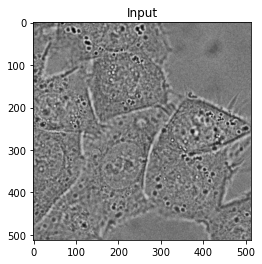

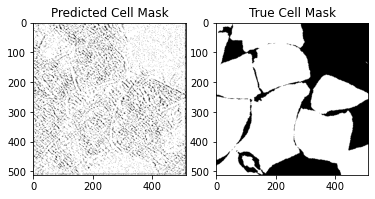

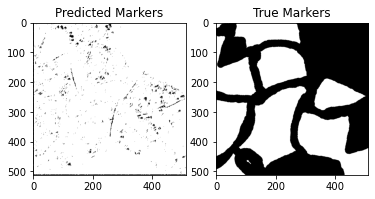

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
--- Evaluation ---
.

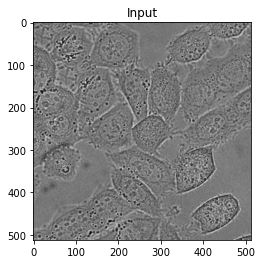

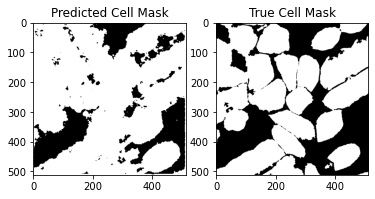

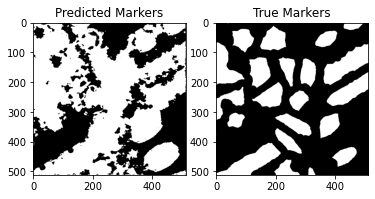

.....................................................................................................................................EPOCH 1 LOSS: 0.180
Min Loss: 0.180


.Epoch: 2, Batch: 1
Loss: 0.19


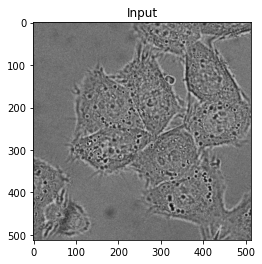

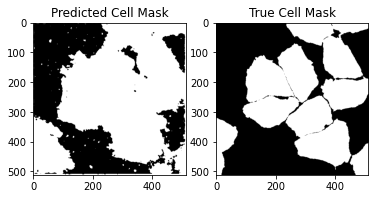

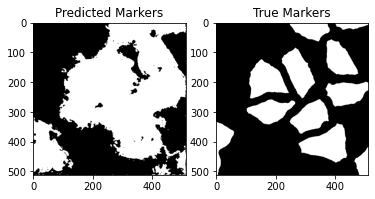

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
--- Evaluation ---
.

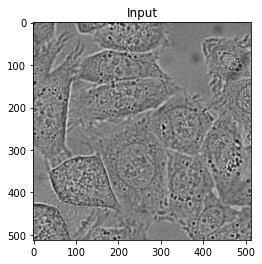

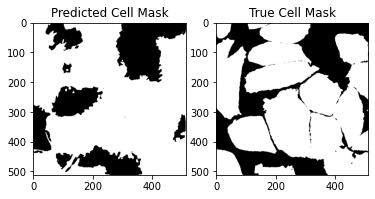

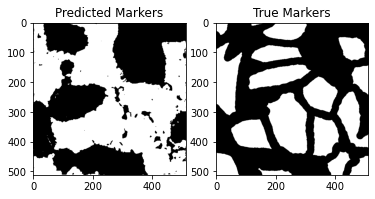

.....................................................................................................................................EPOCH 2 LOSS: 0.158
Min Loss: 0.158


.Epoch: 3, Batch: 1
Loss: 0.15


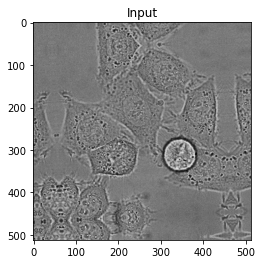

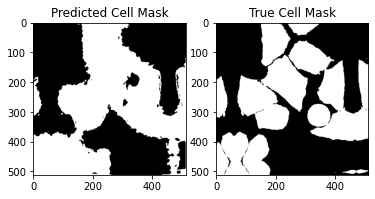

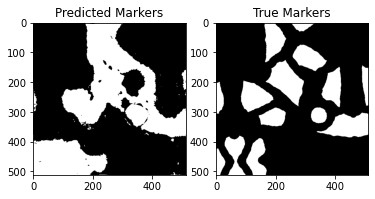

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
--- Evaluation ---
.

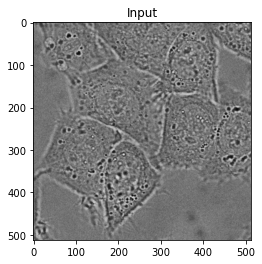

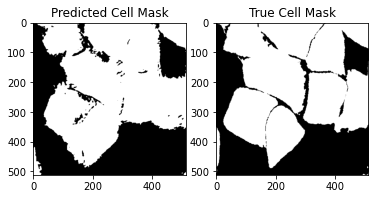

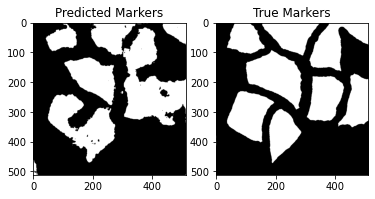

.....................................................................................................................................EPOCH 3 LOSS: 0.117
Min Loss: 0.117


.Epoch: 4, Batch: 1
Loss: 0.10


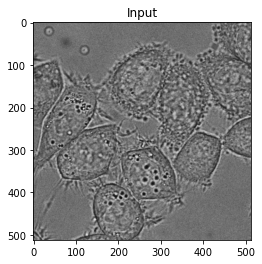

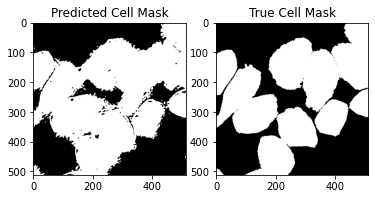

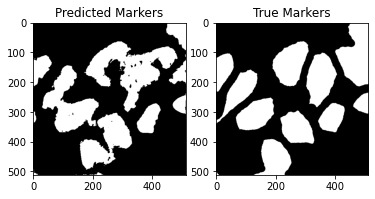

...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
if __name__ == '__main__':
    main()